## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
app = pd.read_csv('application_train.csv')

In [3]:
Y = app['TARGET']
X = app.drop(columns = ['TARGET', 'SK_ID_CURR'])
X1 = app.drop(columns = ['SK_ID_CURR'])

In [4]:
for column in X:
    if X[column].dtype == object:
        X[column] = X[column].fillna('')
    elif X[column].dtype == int:
        X[column] = X[column].fillna(0)
    else:
        X[column] = X[column].fillna(0.)

In [42]:
X_real = X.loc[:, X.dtypes != object]
X_train, X_test, y_train, y_test = train_test_split(X_real, Y, test_size=0.3, random_state=0)

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [6]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score, make_scorer
from time import time as tm

In [53]:
def quality(clf, X, y):
    y_pred = clf.predict_proba(X)[:, 1]
    quality = average_precision_score(y, y_pred)
    return quality

def time(clf, X, y):
    start = tm()
    clf = clf.fit(X, y)
    stop = tm()
    return clf, stop - start

In [8]:
lgbm, t = time(LGBMClassifier(verbose=-1), X_train, y_train)
print(t, quality(lgbm, X_test, y_test))

3.5255119800567627 0.23159230793933594


In [9]:
cb, t = time(CatBoostClassifier(silent=True), X_train, y_train)
print(t, quality(cb, X_test, y_test))

64.81170606613159 0.23355967132379712


__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [9]:
from sklearn.model_selection import GridSearchCV
score = make_scorer(average_precision_score)
params_lgbm = {'max_depth': [2,4,8],
               'n_estimators': [100,500,1000],
               'learning_rate': [0.2,0.1,0.03],
               'objective': ['binary']}
params_cb = {'depth': [2,4,8],
             'iterations': [100,200,300],
             'learning_rate': [0.1,0.03,0.2],
             'loss_function': ['Logloss']}
def best_param(clf, params, X_train, y_train, X_test, y_test):
    res =  GridSearchCV(clf, params, scoring=score, cv=3)
    res, t = time(res, X_train, y_train)
    resa = res.best_params_
    return(print('Best params : ', resa, '\nFit time : ', t, '\nQuality :', quality(res, X_test, y_test)))

In [28]:
best_param(LGBMClassifier(verbose=-1), params_lgbm, X_train, y_train, X_test, y_test)

Best params :  {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 1000, 'objective': 'binary'} 
Fit time :  507.95148158073425 
Quality : 0.2059765437915678


In [27]:
best_param(CatBoostClassifier(silent=True), params_cb, X_train, y_train, X_test, y_test)

Best params :  {'depth': 8, 'iterations': 300, 'learning_rate': 0.2, 'loss_function': 'Logloss'} 
Fit time :  1551.937219619751 
Quality : 0.22313277797722106


__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [10]:
X_OHE = pd.get_dummies(X, drop_first=True, dtype=int)
X_OHE_train, X_OHE_test, y_OHE_train, y_OHE_test = train_test_split(np.array(X_OHE), Y, test_size=0.3, random_state=0)

In [38]:
best_param(LGBMClassifier(verbose=-1), params_lgbm, X_OHE_train, y_OHE_train, X_OHE_test, y_OHE_test)

Best params :  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1000, 'objective': 'binary'} 
Fit time :  677.365483045578 
Quality : 0.2222262313291812


In [39]:
best_param(CatBoostClassifier(silent=True), params_cb, X_OHE_train, y_OHE_train, X_OHE_test, y_OHE_test)

Best params :  {'depth': 8, 'iterations': 300, 'learning_rate': 0.2, 'loss_function': 'Logloss'} 
Fit time :  1710.2108027935028 
Quality : 0.2305768759416202


In [11]:
X_MTE = X1.copy()
C = 100
for column in X1:
    if(X1[column].dtypes == object):
        mean_enc = (X1.groupby(column)['TARGET'].sum() +
                    C * X1['TARGET'].mean()) / (X1.groupby(column)['TARGET'].aggregate(np.size) + C)
        X_MTE[column] = X1[column].map(mean_enc)
X_MTE = X_MTE.drop(columns = ['TARGET'])
X_MTE_train, X_MTE_test, y_MTE_train, y_MTE_test = train_test_split(np.array(X_MTE), Y, test_size=0.3, random_state=0)

In [58]:
best_param(LGBMClassifier(verbose=-1), params_lgbm, X_MTE_train, y_MTE_train, X_MTE_test, y_MTE_test)

Best params :  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1000, 'objective': 'binary'} 
Fit time :  422.0189685821533 
Quality : 0.22349302638635316


In [59]:
best_param(CatBoostClassifier(silent=True), params_cb, X_MTE_train, y_MTE_train, X_MTE_test, y_MTE_test)

Best params :  {'depth': 4, 'iterations': 300, 'learning_rate': 0.2, 'loss_function': 'Logloss'} 
Fit time :  1006.8147356510162 
Quality : 0.24079189888504934


In [12]:
from sklearn.preprocessing import LabelEncoder
X_LE = X.copy()
for column in X:
    if(X[column].dtypes == object):
        le = LabelEncoder()
        X_LE[column]=le.fit_transform(X[column])
X_LE_train, X_LE_test, y_LE_train, y_LE_test = train_test_split(np.array(X_LE), Y, test_size=0.3, random_state=0)

In [49]:
best_param(LGBMClassifier(verbose=-1), params_lgbm, X_LE_train, y_LE_train, X_LE_test, y_LE_test)

Best params :  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1000, 'objective': 'binary'} 
Fit time :  405.8060791492462 
Quality : 0.22485616780120787


In [50]:
best_param(CatBoostClassifier(silent=True), params_cb, X_LE_train, y_LE_train, X_LE_test, y_LE_test)

Best params :  {'depth': 8, 'iterations': 300, 'learning_rate': 0.2, 'loss_function': 'Logloss'} 
Fit time :  992.4496967792511 
Quality : 0.23012567999756225


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [20]:
def predict(clf, X_train, y_train, X_test):
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    return y_pred

In [23]:
y_pred_blend = predict(LGBMClassifier(verbose=-1, learning_rate=0.2, max_depth=4, n_estimators=1000,
                                      objective='binary'), X_OHE_train, y_OHE_train, X_OHE_test)
y_pred_blend += predict(CatBoostClassifier(silent=True, depth=8, iterations=300, learning_rate=0.2,
                                           loss_function='Logloss'), X_OHE_train, y_OHE_train, X_OHE_test)
y_pred_blend += predict(LGBMClassifier(verbose=-1, learning_rate=0.2, max_depth=4, n_estimators=1000,
                                      objective='binary'), X_MTE_train, y_MTE_train, X_MTE_test)
y_pred_blend += predict(CatBoostClassifier(silent=True, depth=4, iterations=300, learning_rate=0.2,
                                           loss_function='Logloss'), X_MTE_train, y_MTE_train, X_MTE_test)
y_pred_blend += predict(LGBMClassifier(verbose=-1, learning_rate=0.2, max_depth=4, n_estimators=1000,
                                      objective='binary'), X_LE_train, y_LE_train, X_LE_test)
y_pred_blend += predict(CatBoostClassifier(silent=True, depth=8, iterations=300, learning_rate=0.2,
                                           loss_function='Logloss'), X_LE_train, y_LE_train, X_LE_test)
y_pred_blend /= 6

average_precision_score(y_test, y_pred_blend)

0.2436453514586711

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

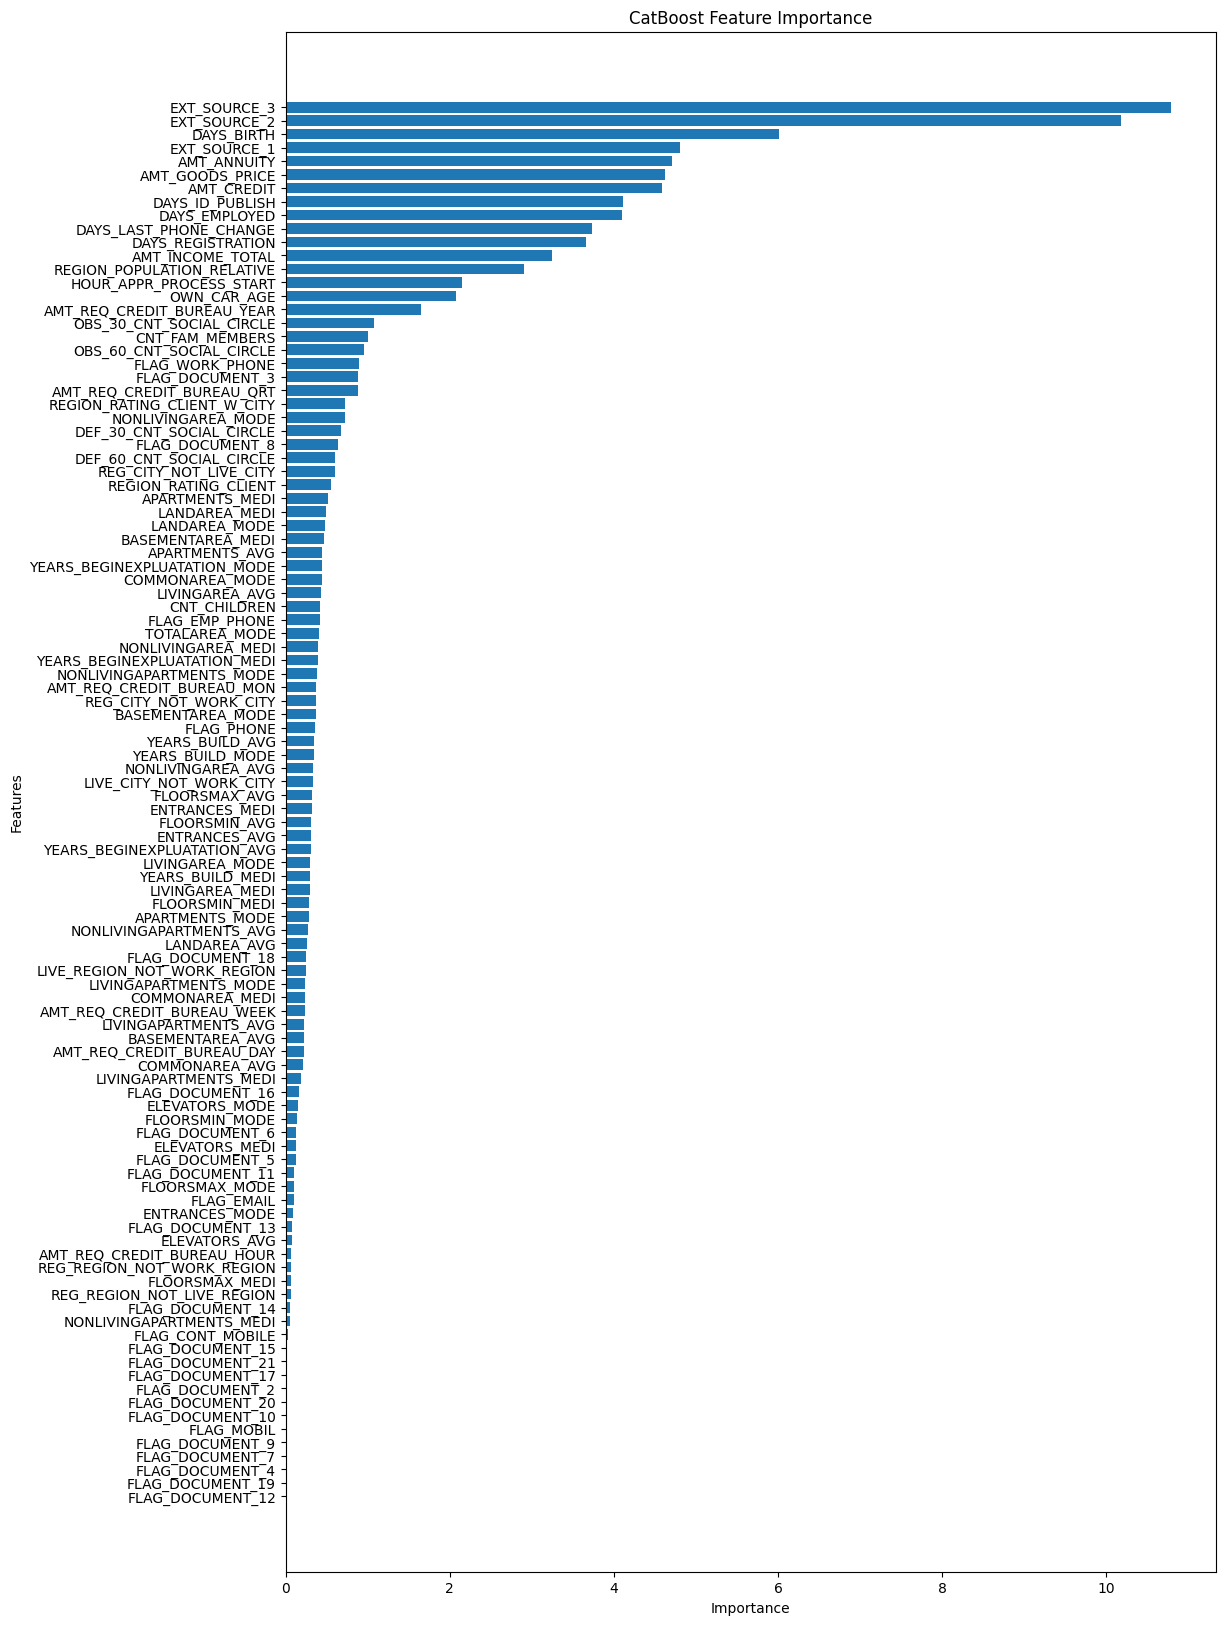

In [77]:
cb = CatBoostClassifier(silent=True, depth=8, iterations=300, learning_rate=0.2, loss_function='Logloss')
cb = cb.fit(X_train, y_train)
importances_cb = cb.get_feature_importance()
feature_importances_cb = pd.Series(importances_cb, index=X_train.columns).sort_values()
plt.figure(figsize=(12, 20))
plt.barh(feature_importances_cb.index, feature_importances_cb.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [84]:
feature_importances_c = feature_importances_cb.index[15:]
cb, t = time(CatBoostClassifier(silent=True, depth=8, 
                           iterations=300, learning_rate=0.2, loss_function='Logloss'), 
             X_train[feature_importances_c], y_train)
print(t, quality(cb, X_test[feature_importances_c], y_test))

25.176570415496826 0.2244441438586779


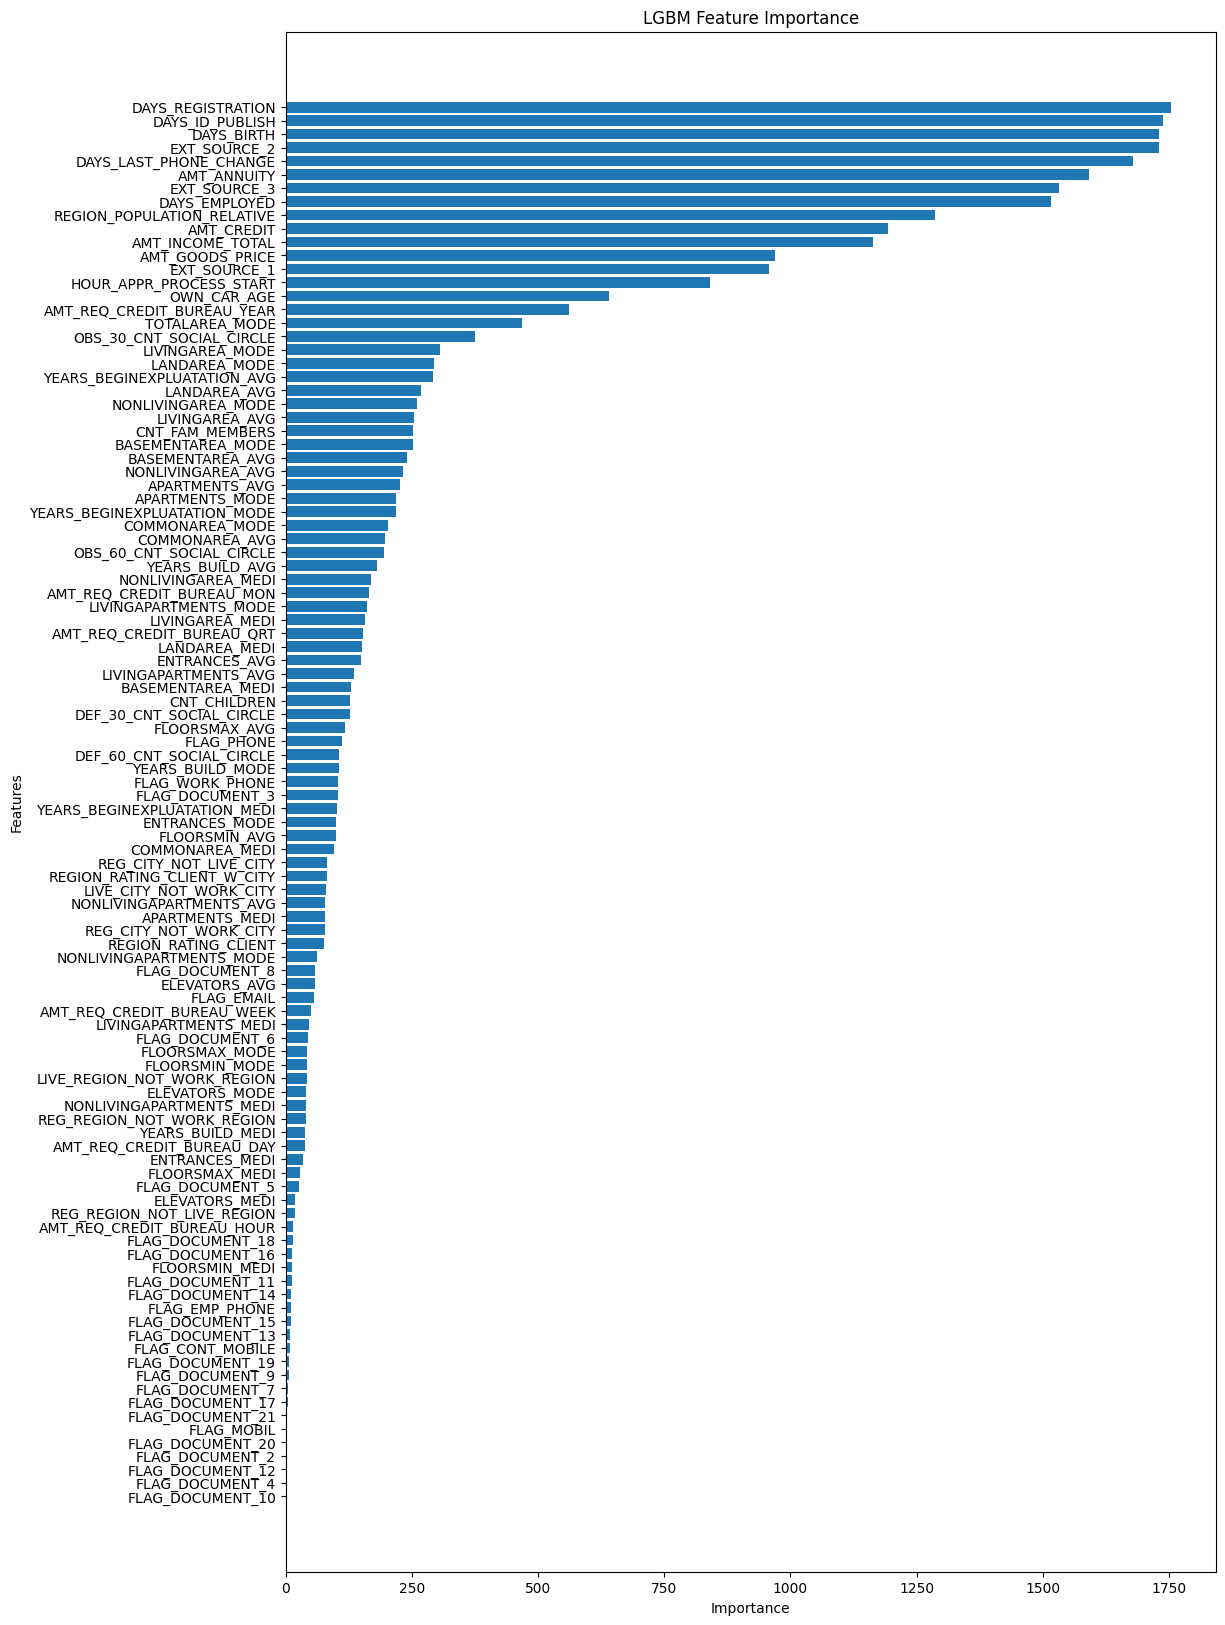

In [79]:
lgbm = LGBMClassifier(verbose=-1, learning_rate=0.2, max_depth=8, n_estimators=1000, objective='binary')
lgbm = lgbm.fit(X_train, y_train)
importances_lgbm = lgbm.feature_importances_
feature_importances_lgbm = pd.Series(importances_lgbm, index=X_train.columns).sort_values()
plt.figure(figsize=(12, 20))
plt.barh(feature_importances_lgbm.index, feature_importances_lgbm.values)
plt.title('LGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [87]:
feature_importances_l = feature_importances_lgbm.index[18:]
lgbm, t = time(LGBMClassifier(verbose=-1, learning_rate=0.2, max_depth=8, n_estimators=1000, objective='binary'), 
             X_train[feature_importances_l], y_train)
print(t, quality(lgbm, X_test[feature_importances_l], y_test))

15.169311761856079 0.20770362788470326
